<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/Benchmark_models_and_bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmark models and bootstrap
In this group work we will try to retrieve confidence intervals for the simple benchmark models we've seen in the last exercise.
Remember that, for univariate series, the observations $y$ can be always rewritten as:
$$y = \hat{y} + \epsilon = f(y_{T}) + \epsilon$$
where $y_{T}$ denotes all the observations used to train the model $[y_t]_{t=1}^T$. The distributions of the forecasters we have seen in the lessons: 
\begin{aligned}
 \text{mean method}: \quad y_{T+h \mid T} &\sim \mathcal{N}\left(\bar{y},(1+1 / T) \hat{\sigma}^2\right) \\
 \text{naive method}: \quad y_{T+h \mid T} &\sim \mathcal{N}\left(y_T, h \hat{\sigma}^2\right) \\
 \text{seasonal naive method}: \quad y_{T+h \mid T} &\sim \mathcal{N}\left(y_{T+h-m(k+1)},(k+1) \hat{\sigma}^2\right)
\end{aligned}

are obtained under the hypothesis of $ \epsilon$ being i.i.d. and normally distributed $\mathcal{N}(0, σ)$. 

###❓Q1 Check error hypothesis 
For all the datasets and for all the benchmark methods, retrieve the distributions of the one step-ahead errors and try to see if $ \epsilon \sim \mathcal{N}(0, σ)$ and i.i.d.
You can use one/two among histograms, q-q plots, normality tests, ACF or the Ljung-Box test. 

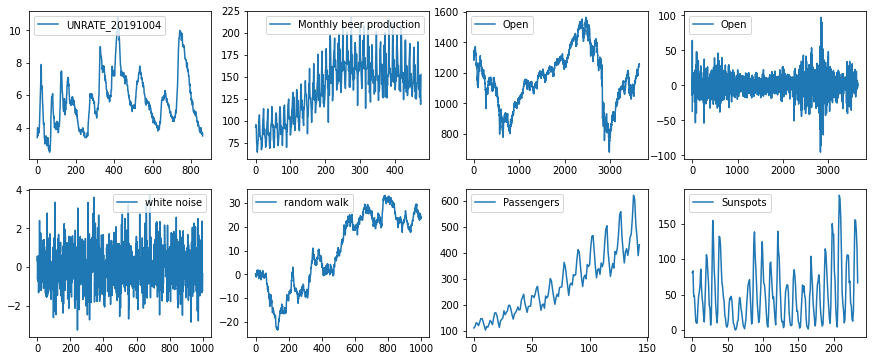

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

df_uschange = pd.read_csv('https://raw.githubusercontent.com/robjhyndman/fpp3package/master/data-raw/US_change/uschange_fpp3_Monthly.txt', delimiter='\t', index_col='observation_date')
df_uschange.index = pd.DatetimeIndex(df_uschange.index)

df_beer = pd.read_csv('https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv', index_col='Month', parse_dates=True)
df_beer.index = pd.DatetimeIndex(df_beer.index)

df_goog = pd.read_csv('https://raw.githubusercontent.com/bharatpurohit97/StockPrediction/master/ReinforcementLearning-YahooFinance/data/%5EGSPC.csv', index_col='Date', parse_dates=True)[['Open']]
df_goog.index = pd.DatetimeIndex(df_goog.index)
df_goog = df_goog.resample('1d').mean().interpolate('linear')

df_air = pd.read_csv('https://raw.githubusercontent.com/Manishms18/Air-Passengers-Time-Series-Analysis/master/Data/AirPassengers.csv', index_col='Month', parse_dates=True)

df_sun = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv', index_col='Month', parse_dates=True)
df_sun.index = pd.DatetimeIndex(df_sun.index)
df_sun = df_sun.resample('y').mean()
df_sun = df_sun.interpolate('linear')

n = 1000
df_rn = pd.DataFrame(np.random.randn(n), index=pd.date_range('2023', periods=n), columns=['white noise'])
df_rw = pd.DataFrame(np.cumsum(np.random.randn(n)), index=pd.date_range('2023', periods=n),columns=['random walk'])

dfs = [df_uschange, df_beer, df_goog, df_goog.diff().iloc[1:], df_rn, df_rw, df_air, df_sun]
dfs = [df.reset_index(drop=True) for df in dfs]
names = ['uschange', 'beer', 'goog', 'goog diff', 'RN', 'RW', 'air', 'sunspots']

fig, ax = plt.subplots(2, 4, figsize=(15, 6))
for a, df in zip(ax.ravel(), dfs):
    df.plot(ax=a)

In [2]:
p = 12
mean = lambda x, h: pd.DataFrame(np.tile(x.mean(), h), index=x.index[-1]+np.arange(1, 1+h), columns=x.columns)
seasonal = lambda x, h: pd.DataFrame(np.tile(x.iloc[-p:].values.ravel(), int(p*np.ceil(h/p)))[:h], index=x.index[-1]+np.arange(1, 1+h), columns=x.columns)
naive = lambda x, h: pd.DataFrame(np.tile(x.iloc[-1], h), index=x.index[-1]+np.arange(1, 1+h), columns=x.columns)
forecasters = [naive, mean, seasonal]
forecasters_names = ['naive', 'mean', 'seasonal']

In [ ]:
def get_errs(df_tr, forecaster, steps_ahead):
  """
  Returns a pd.DataFrame of dimension (T, steps_ahead) containing the forecast 
  errors, running the forecaster on the input DataFrame df_tr
  """

errs = get_errs(df, naive, 3)
errs.head()

In [ ]:
def get_all_errs(dfs, names, forecasters, forecasters_names,steps_ahead=1, test_samples=48, do_plots=True):
  """
  Runs get_errs on all the (dataset,forecasters) tuples and return error 
  matrices and error standard deviations  
  """
  if do_plots:
    fig, ax = plt.subplots(2, 4, figsize=(20, 8))
  stds = {}
  all_errs = {}
  for df, name, a in zip(dfs, names, ax.ravel()):
      errs = {}
      for f, f_name in zip(forecasters, forecasters_names):
          print('retrieving errs {} on dataset {}'.format(f_name, name))
          df_tr = df.iloc[:-test_samples]
          errs[f_name] = get_errs(df_tr, f, steps_ahead)
      all_errs[name] = pd.concat(errs,axis=1)
      stds[name] = all_errs[name].std()
      if do_plots:
        sb.histplot(all_errs[name], ax=a)
        a.set_title(name)
  return all_errs, stds
all_errs, stds = get_all_errs(dfs, names, forecasters, forecasters_names, steps_ahead=1, test_samples=48, do_plots=True)
stds = pd.concat(stds)
print('standard deviations of the errors for step 0:')
print(stds)

###❓Q2 Confidence intervals
Retrieve the theoric confidence intervals for all the datasets for one of the benchmark method. You will need to estimate $\sigma$ from the error distribution you already retrieve. Under normality assumption, you can retrieve the $\alpha\%$ confidence interval knowing the $(1-\alpha)/2 + \alpha$ quantile of the normal distribution. Why?
### Recap on CIs retrieval
To retrieve the $\alpha \%$ CIs for a $\mathcal{N}(y, \sigma^2 )$ we can use the following procedure:
* obtain the quantile $(1-\alpha)/2 + \alpha$ from the standard normal distribution $\mathcal{N}(0,1)$, call it $q_{\alpha}$
* Since the following identity holds: $$y + \sigma\mathcal{N}(0,1) = \mathcal{N}(y,\sigma^2)$$
we can obtain the upper limit as  $y + \sigma q_{\alpha}$
* obtain the symmetric (w.r.t. y) CIs as $y ± \sigma q_{\alpha}$

Use the `norm.ppf` function from scipy.stats to retrieve the quantiles of the standard normal distribution.  

In [ ]:
from scipy.stats import norm
def get_ci(y, std, alpha, m):
  """
  Returns a (2, steps_ahead) matrix containing the alpha-level CI for the 
  forecast y, which has length steps_ahead. Ignore m if the method is not 
  seasonal naive
  """
steps_ahead = 12
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for a, df, n in zip(ax.ravel(), dfs, names):
    df.reset_index(drop=True, inplace=True)
    df_tr, df_te = df.iloc[:-steps_ahead], df.iloc[-steps_ahead:]
    y_hat = naive(df_tr, steps_ahead)
    std = stds[n]['naive'].values
    cis_90 = get_ci(y_hat, std, 0.9, 0)
    cis_50 = get_ci(y_hat, std, 0.5, 0)
    a.plot(df_tr.iloc[-200:])
    a.plot(y_hat)
    a.plot(df_te)
    a.fill_between(cis_90.index, *cis_90.values.T, alpha=0.2)
    a.fill_between(cis_50.index, *cis_50.values.T, alpha=0.2)


### ❓Q3 Use the empirical distributions to retrieve the CIs
Instead of using the theorical formula for the quantiles, try to use the historical error distirbution for n steps ahead to retrieve the error quantiles.
Use just one forecasting method, for all the datasets retrieve the error matrices $\epsilon_{t, h}$ where $t$ is the time at which the prediction was done and $h$ is the step ahead.

In [ ]:
all_errs, stds = get_all_errs(dfs, names, [naive],['naive'], steps_ahead=steps_ahead, test_samples=48, do_plots=True)

In [ ]:
steps_ahead = 12
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for a, df, n in zip(ax.ravel(), dfs, names):
    df.reset_index(drop=True, inplace=True)
    df_tr, df_te = df.iloc[:-steps_ahead], df.iloc[-steps_ahead:]
    y_hat = naive(df_tr, steps_ahead)
    cis_90 = 0 # Fill this
    cis_50 = 0 # Fill this
    a.plot(df_tr.iloc[-200:])
    a.plot(y_hat)
    a.plot(df_te)
    a.fill_between(y_hat.index, *cis_90, alpha=0.2)
    a.fill_between(y_hat.index, *cis_50, alpha=0.2)

### ❓Q4 Generate scenarios 
Instead of plotting the error distributions $\varepsilon_{h}$, just draw n error scenarios at random from the $\epsilon_{t, h}$ matrices and plot them


In [ ]:
n_scens=50
steps_ahead = 12
fig, ax = plt.subplots(2, 4, figsize=(30, 12))
for a, df, n in zip(ax.ravel(), dfs, names):
    df.reset_index(drop=True, inplace=True)
    df_tr, df_te = df.iloc[:-steps_ahead], df.iloc[-steps_ahead:]
    y_hat = naive(df_tr, steps_ahead)
    cis_90 = 0 # Fill this
    cis_50 = 0 # Fill this
    scens = (all_errs[n].loc[np.random.choice(all_errs[n].index, n_scens)]+y_hat.values.reshape( 1, -1)).T
    a.plot(np.tile(y_hat.index.values.reshape(-1, 1), n_scens), scens.values, alpha=0.2)
    a.plot(df_tr.iloc[-100:])
    a.plot(y_hat, linewidth=3)
    a.plot(df_te, linewidth=3)
    #a.fill_between(y_hat.index, *cis_90, alpha=0.1)
    #a.fill_between(y_hat.index, *cis_50, alpha=0.1)